# Delaware Case Study
## Simple Model of SGD



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport SGD,utils
import os
from pathlib import Path
import sys
import numpy as np
import numpy.matlib as matlib
import matplotlib.pyplot as plt
import matplotlib.colors
import warnings

#Name model
modelname = 'varheight'

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
import SGD

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('flopy version: {}'.format(flopy.__version__))

if sys.platform == "darwin":
    model_ws = os.path.join('/Users/ianpg/Documents/ProjectsLocal/DelawareSGD','work',modelname)
elif sys.platform == "win32":
    model_ws = os.path.join('E:\Projects\DelawareSGD','work',modelname)

if not os.path.exists(model_ws):
    os.makedirs(model_ws)
sys.path.append(os.path.join(model_ws,'..','..'))
import config
sw_exe = config.swexe #set the exe path for seawat
print('Model workspace:', os.path.abspath(model_ws))

3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 09:55:02) 
[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]
numpy version: 1.13.1
flopy version: 3.2.10
Model workspace: /Users/ianpg/Documents/ProjectsLocal/DelawareSGD/work/varheight


In [2]:
#Other functions and imports

#nearest value in array
def find_nearest(array,value):
    import numpy as np
    idx = (np.abs(array-value)).argmin()
    idx.astype('int')
    return array[idx]

#take distance in meters, return column in model
def loc_to_col(locs):
    cols = [int(find_nearest((np.arange(ncol)*delc),loc)) for loc in locs]
    return cols

#make a line across the grid
def get_line(start, end,allrows=1,nrow=None):
    """Bresenham's Line Algorithm
    Produces a list of tuples from start and end
 
    >>> points1 = get_line((0, 0), (3, 4))
    >>> points2 = get_line((3, 4), (0, 0))
    >>> assert(set(points1) == set(points2))
    >>> print points1
    [(0, 0), (1, 1), (1, 2), (2, 3), (3, 4)]
    >>> print points2
    [(3, 4), (2, 3), (1, 2), (1, 1), (0, 0)]
    """
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
 
    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)
 
    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
 
    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
 
    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1
 
    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1
 
    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        if allrows==1:
            if nrow is None:
                nrow = m.nrow
            for row in range(nrow):
                coord = (y, row, x) if is_steep else (x, row, y)
                points.append(coord)
        else:
            coord = (y, x) if is_steep else (x, y)
            points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx
 
    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    return points


#make all cells=0 above the line from get_line()
#Calculate freshwater head based on column of saltwater above each node (rho*g*z)
def shade_above(nlay,nrow,ncol,point_list,third_dim=1):
    import numpy as np
    grd = np.ones((nlay,nrow,ncol),dtype='int')
    ocean_hf = []
    if len(point_list)==0:
        return grd,ocean_hf
    for (lay,row,col) in point_list:
        grd[lay,:,col] = -1 #assign ocean ibound to -1
        grd[:lay,:,col] = 0 #assign cells above ocean to 0
        hf = densefresh/densesalt*ocean_elev - (densesalt - densefresh)/densefresh*(henry_botm[lay] +.5*delv)
        for irow in range(nrow):
            ocean_hf.append((int(lay),int(irow),int(col),hf))
    ocean_hf = tuple(np.array(ocean_hf).T)
    ocean_hf = (ocean_hf[0].astype('int'),
                ocean_hf[1].astype('int'),
                ocean_hf[2].astype('int'),
                ocean_hf[3])
    return grd,ocean_hf

def get_ocean_right_edge(m,ocean_line_tuple):
    import numpy as np
    point_list = []
    
    #If there is no vertical side boundary, return bottom-right corner node
    if len(ocean_line_tuple)==0:
        startlay = 0
    elif max(ocean_line_tuple[0])==m.nlay:
        startlay = m.nlay
    elif max(ocean_line_tuple[0])<m.nlay:
        startlay = max(ocean_line_tuple[0])
    for lay in range(startlay,m.nlay):
        for row in range(m.nrow):
            point_list.append((lay,row,m.ncol-1))
    point_list = tuple(np.array(point_list).T)
    return point_list

#create random clay blocks throughout model (quick dirty way to do heterogeneity)
def rand_clay_blocks(lithmat,hkClay,numblocks,sizeblocks):
    nlay,nrow,ncol = lithmat.shape
    lay_block = np.random.randint(1,nlay-sizeblocks[0],numblocks)
    row_block = np.random.randint(0,nrow-sizeblocks[1]+1,numblocks)
    col_block = np.random.randint(1,ncol-sizeblocks[2],numblocks)
    lithmat_blocks = lithmat.copy()
    for i in range(numblocks):
        block_coords = [slice(lay_block[i],lay_block[i]+sizeblocks[0]),
                        slice(row_block[i],row_block[i]+sizeblocks[1]),
                        slice(col_block[i],col_block[i]+sizeblocks[2])]
        lithmat_blocks[block_coords] = hkClay
    return lithmat_blocks

In [3]:
80*40

3200

In [148]:
#Model grid
#Grid: 0.5 *1*1m • Size:70m*20m
Lx = 5000.
Ly = 1.
Lz = 80.
xul=488930.5-3 #minimum x value - 3
yul=4271464.0-32 #minimum y value -32 to place in front of breakwater
rotation=0
nlay = int(Lz*1/3)
nrow = int(Ly)
ncol = int(Lx*(1/50))
delr = Lx / ncol
delc = Ly / nrow
delv = Lz / nlay

beachslope = .05
henry_top = 0
henry_botm = np.linspace(henry_top - delv, henry_top - Lz, nlay)

##dev
#Create ocean boundary at top of model
ocean_col = [np.floor(ncol-1).astype('int'),ncol-1] #Manually done to make sure it's in the right place rn

ocean_elev = 0
inland_elev = beachslope*ocean_col[0]*delr
offshore_elev = -beachslope*(ocean_col[1]-ocean_col[0])*delr

#beach_arr = matlib.repmat(np.linspace(inland_elev,offshore_elev,num=ncol),nrow,1)
#henry_top = ocean_elev*np.ones((nrow,ncol), dtype=np.float) + beach_arr
#henry_botm = matlib.repmat(np.linspace(ocean_elev - delv, ocean_elev - Lz, nlay),ncol,1).transpose() + beach_arr[1]
#henry_botm = np.transpose(np.tile(henry_botm,(nrow,1,1)),
#                          (1,0,2))
##dev


#Period data
perlen = [100,100,50000]
nstp = [5,5,5]
nper = len(perlen)
steady = [False for x in range(len(perlen))] #Never steady
itmuni = 4 #time unit 4= days
lenuni = 2 #length unit 2 = meter
tsmult = 1.8
ssm_data = None
verbose = True

In [149]:
#Create basic model instance and dis pacakge
m = flopy.seawat.Seawat(modelname, exe_name=sw_exe, model_ws=model_ws,verbose=verbose)
SGD.ModelSGD.Seawat2SGD(m)  #convert to subclass ModelSGD
print(m.namefile)

# Add DIS package to the MODFLOW model
dis = flopy.modflow.ModflowDis(m, nlay, nrow, ncol, nper=nper, delr=delr,
                               delc=delc, xul=xul, yul=yul, rotation=rotation,
                               laycbd=0, top=henry_top,
                               botm=henry_botm, perlen=perlen, nstp=nstp,
                               steady=steady,itmuni=itmuni,lenuni=lenuni,
                               tsmult=tsmult)

varheight.nam
adding Package:  DIS


In [150]:
#Hydraulic conductivity field 
hkSand = 80.  #horizontal hydraulic conductivity m/day
hkClay = 1. 
lithmat = hkSand*np.ones((nlay,nrow,ncol), dtype=np.int32) #sandy background
addclay_yn = 0

#add random low conductivity regions
if addclay_yn == 1:
    lithmat = rand_clay_blocks(lithmat,hkClay,100,(2,1,5))

In [151]:
#Set Hydraulic properties

hk = lithmat
sy = 0.15
ss = 0.00005
por = 0.2
vka = 1/10 # = vk/hk
al = 10 #longitudinal dispersivity (m) from Walther et al. 2017
dmcoef = 2e-9 #m2/day  from Walther et al. 2017
#dmcoef = 1.62925 #is a case of the Henry problem

#### FOR TESTING
#al = 0
#dmcoef = 0. #test for numerical dispersion
#### FOR TESTING

#Variable density parameters
Csalt = 35.0001
Cfresh = 0.
densesalt = 1025.
densefresh = 1000.
denseslp = (densesalt - densefresh) / (Csalt - Cfresh)
#denseslp = 0 #trick for testing constant density

In [152]:
def rand_clay_blocks(lithmat,hkClay,numblocks,sizeblocks):
    nlay,nrow,ncol = lithmat.shape
    lay_block = np.random.randint(1,nlay-sizeblocks[0],numblocks)
    row_block = np.random.randint(0,nrow-sizeblocks[1]+1,numblocks)
    col_block = np.random.randint(1,ncol-sizeblocks[2],numblocks)
    lithmat_blocks = lithmat.copy()
    for i in range(numblocks):
        block_coords = [slice(lay_block[i],lay_block[i]+sizeblocks[0]),
                        slice(row_block[i],row_block[i]+sizeblocks[1]),
                        slice(col_block[i],col_block[i]+sizeblocks[2])]
        lithmat_blocks[block_coords] = hkClay
    return lithmat_blocks

def rand_wel_location():
    import scipy.stats as sts
    col = sts.randint.rvs(1,ocean_col[1]-2)
    row = sts.randint.rvs(0,nrow)
    return row,col

def rand_flux(low=1e-6,high=1e-2):
    import scipy.stats as sts
    flx = sts.uniform.rvs(low,high)
    return flx

def add_pumping_wells(wel_data,ssm_data,n_wells,flx_generator,loc_generator,*args):
    itype = flopy.mt3d.Mt3dSsm.itype_dict()
    new_weldata = wel_data
    new_ssmdata = ssm_data
    for k in range(n_wells):
        row,col = loc_generator()
        flx = flx_generator(*args)
        for i in range(nper):
                for j in range(nlay):
                    #WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append([j,row,col,-flx/(nlay)])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    new_ssmdata[i].append([j,row,col,Cfresh,itype['WEL']]) #since it's a sink, conc. doesn't matter
    return new_weldata, new_ssmdata

In [153]:
#BCs
bc_ocean = 'GHB'
bc_right_edge = 'GHB'
bc_inland = 'WEL'
add_wells = 1
n_wells = 2

#BC values 
#Inland
calc_inland_head = 0 #calculate from hgrad
#manual_inland_head = henry_top + .1
manual_inland_head = .75
#influx = hkSand*delr*delv*hgrad*nlay #m^3/day through inland boundary
influx = 1.41e-7 *(delc*nrow)*(delv*nlay) #from Walther et. al 2017
influx = 0.015*(delc*nrow)*(delv*nlay)

#Ocean
ocean_shead = [henry_top]
ocean_ehead = ocean_shead
start_fresh_yn = 1

##dev
ocean_shead = [ocean_elev for x in range(len(perlen))] 
ocean_ehead = ocean_shead
##dev


# save cell fluxes to unit 53
ipakcb = 53

#MODFLOW BCs
hgrad = 0.0033 #hydraulic gradient, m/m
qinflow = 0  #influent FW m3/day

#Create ocean boundary at top of model
ocean_col_vec = (0,0,np.arange(ocean_col[0],ocean_col[1]+1))
ocean_coords = (0,slice(0,nrow),slice(ocean_col[0],ocean_col[1]+1)) #top of the model
ocean_bool = np.zeros((nlay,nrow,ncol), dtype=bool)
ocean_bool[0,:,np.arange(ocean_col[0],ocean_col[1]+1)] = 1
m.ocean_arr = ocean_bool


if calc_inland_head == 1:
    head_inland = ocean_col[0]*delc*hgrad + ocean_elev
else:
    head_inland = manual_inland_head

####IN TESTING#####
#Create a line of where the ocean is, and any nodes on right edge below ocean
offshore_lay = (np.abs(henry_botm-offshore_elev)).argmin().astype('int')
if ocean_col[0] == ncol-1:
    ocean_line = []
    bc_ocean = 'XXX'
else:
    ocean_line = get_line((0,ocean_col[0]),(offshore_lay,ocean_col[1]),allrows=1,nrow=1)

ocean_line_tuple = tuple(np.array(ocean_line).T) #use this for indexing numpy arrays
right_edge = get_ocean_right_edge(m,ocean_line_tuple)

#Create ibound
ibound,ocean_hf = shade_above(nlay,nrow,ncol,ocean_line) #don't set ibound of ocean
#ibound = np.ones((nlay,nrow,ncol),dtype=np.int)
if bc_ocean == 'GHB':
    ibound[ocean_line_tuple]=1
#ibound[:, :, 0] = -1 #first column (FW boundary) has fixed head
#ibound[0:1,:,ocean_col[0]-3:ocean_col[0]] = 0 #small block before beach is no-flow

if bc_right_edge =='CHD':
    ibound[right_edge] = -1


#Set starting heads
strt = ocean_elev*np.ones((nlay, nrow, ncol),dtype='float') #starting heads
if bc_inland=='CHD':
    strt[:,:,0] = head_inland #head inland
if len(ocean_hf)>0:
    strt[ocean_hf[0],
        ocean_hf[1],
        ocean_hf[2]] = ocean_hf[3] #self-calculate equivalent FW head; this is repeated in CHD/GHB package
    right_edge_hf = ocean_hf[3][-1] - (densesalt - densefresh)/densefresh*(henry_botm[right_edge[0]] +.5*delv)
else:
    right_edge_hf = -(densesalt - densefresh)/densefresh*(henry_botm[right_edge[0]] +.5*delv)

strt[right_edge] = right_edge_hf
#strt[right_edge] = ocean_hf[3][-1] #set right (ocean) edge below the sloped boundary
#strt[ocean_hf[0][-1] +1:,:,-1] = ocean_hf[3][-1]
strt = np.zeros((nlay,nrow,ncol),dtype=np.int)


#Transport BCs
if start_fresh_yn == 1:
    sconc = Cfresh*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin fresh
elif start_fresh_yn == 0:
    sconc = Csalt*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin SW-saturated
else:
    sconc = Cfresh*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin SW-saturated
    sconc[:,:,int(np.floor(ncol/2)):-1] = Csalt

if ocean_hf:
    sconc[ocean_hf[0:3]] = Csalt
sconc[:,:,-1] = Csalt
sconc[:,:,0] = Cfresh

icbund = np.ones((nlay, nrow, ncol), dtype=np.int) 
### If using SSM, I think we don't need to hold cells as constant concentration
#icbund[(ibound < 0)] = -1 #constant concentration cells where also constant head
#icbund[:,:,0] = -1 #right now hold inland boundary to constant concentration
icbund[np.where(ibound==-1)] = -1

def make_bc_dicts():
    #Ocean and inland boundary types
    itype = flopy.mt3d.Mt3dSsm.itype_dict()
    chd_data = {}
    ssm_data = {}
    ghb_data = {}
    wel_data = {}
    for i in range(nper):
        dat_chd = []
        dat_ssm = []
        dat_ghb = []
        dat_wel = []
        #Ocean boundary
        if ocean_hf:
            for j in range(np.size(ocean_hf[0])):
                if bc_ocean=='CHD':
                    #CHD: {stress_period: [lay,row,col,starthead,endhead]}
                    dat_chd.append([ocean_line_tuple[0][j],
                                ocean_line_tuple[1][j],
                                ocean_line_tuple[2][j],
                                ocean_shead[i],
                                ocean_ehead[i]])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    dat_ssm.append([ocean_line_tuple[0][j],
                                ocean_line_tuple[1][j],
                                ocean_line_tuple[2][j],
                                Csalt,
                                itype['CHD']])
                elif bc_ocean=='GHB':
                    #GHB: {stress period: [lay,row,col,head level,conductance]}
                    #conductance c = K*A/dL; assume horizontal flow at outlet,
                    #and calculate length to be at edge of ocean cell, as opposed to mipoint
                    # c = (K*dy*dz)/(dx/2) = 2*K*delr*delv/delc
                    dat_ghb.append([ocean_hf[0][j],
                                   ocean_hf[1][j],
                                   ocean_hf[2][j],
                                   #ocean_hf[3][j],
                                    ocean_elev-henry_top,
                                   2*hkSand*delc*delv/delr])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    dat_ssm.append([ocean_hf[0][j],
                                   ocean_hf[1][j],
                                   ocean_hf[2][j],
                                   Csalt,
                                   itype['GHB']])
        else:
            pass
        #Right edge boundary
        if bc_right_edge=='GHB':
            for j in range(np.size(right_edge[0])):
                #GHB: {stress period: [lay,row,col,head level,conductance]}
                #conductance c = K*A/dL; assume horizontal flow at outlet,
                #and calculate length to be at edge of ocean cell, as opposed to mipoint
                # c = (K*dy*dz)/(dx/2) = 2*K*delr*delv/delc
                dat_ghb.append([right_edge[0][j],
                               right_edge[1][j],
                               right_edge[2][j],
                               #ocean_hf[3][j],
                                ocean_elev-henry_top,
                               2*hkSand*delc*delv/delr])
                #SSM: {stress_period: [lay,row,col,concentration,itype]}
                dat_ssm.append([right_edge[0][j],
                               right_edge[1][j],
                               right_edge[2][j],
                               Csalt,
                               itype['GHB']])
        else:
            pass
        #Inland boundary
        if bc_inland=='GHB':
            for j in range(nlay):
                for k in range(nrow):
                    #GHB: {stress period: [lay,row,col,head level,conductance]}
                    dat_ghb.append([j,k,0,head_inland,
                                    2*hkSand*delc*delv/delr])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    dat_ssm.append([j,k,0,Cfresh,itype['GHB']])
        elif bc_inland=='WEL':
            for j in range(nlay):
                for k in range(nrow):
                    #WEL: {stress_period: [lay,row,col,flux]}
                    dat_wel.append([j,k,0,influx/(nlay*nrow)])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    dat_ssm.append([j,k,0,Cfresh,itype['WEL']])
        chd_data[i] = dat_chd
        ssm_data[i] = dat_ssm
        ghb_data[i] = dat_ghb
        wel_data[i] = dat_wel

    #saving concentrations at specified times
    #timprs = [k for k in range(1,np.sum(perlen),50)]
    return chd_data, ssm_data, ghb_data, wel_data

chd_data, ssm_data, ghb_data, wel_data = make_bc_dicts()
timprs = np.round(np.linspace(1,np.sum(perlen),20),decimals=0)

In [182]:
chd_data, ssm_data, ghb_data, wel_data = make_bc_dicts()
if add_wells==1:
    args = (1e-1,1e0)
    wel_data,ssm_data = add_pumping_wells(wel_data,ssm_data,n_wells,rand_flux,rand_wel_location,*args)

In [167]:
savehead = []
oc_data = {}
for kper,ksteady,kstp,klen in zip(range(len(nstp)),steady,nstp,perlen):
    print(kper,ksteady,kstp,klen)
    for ik in range(kstp):
        #if ik==0:
        savehead =(ik,kper)
        oc_data[savehead]= ['save head','save budget']
print(oc_data)

0 False 5 100
1 False 5 100
2 False 5 50000
{(0, 0): ['save head', 'save budget'], (1, 0): ['save head', 'save budget'], (2, 0): ['save head', 'save budget'], (3, 0): ['save head', 'save budget'], (4, 0): ['save head', 'save budget'], (0, 1): ['save head', 'save budget'], (1, 1): ['save head', 'save budget'], (2, 1): ['save head', 'save budget'], (3, 1): ['save head', 'save budget'], (4, 1): ['save head', 'save budget'], (0, 2): ['save head', 'save budget'], (1, 2): ['save head', 'save budget'], (2, 2): ['save head', 'save budget'], (3, 2): ['save head', 'save budget'], (4, 2): ['save head', 'save budget']}


In [168]:
#Create instances in flopy
bas = flopy.modflow.ModflowBas(m, ibound, strt=strt)
if bc_ocean=='CHD' or bc_inland=='CHD' :
    chd = flopy.modflow.ModflowChd(m, stress_period_data=chd_data)
if bc_ocean=='GHB' or bc_inland=='GHB'or bc_right_edge=='GHB':
    ghb = flopy.modflow.ModflowGhb(m, stress_period_data=ghb_data)
if bc_ocean=='WEL' or bc_inland=='WEL':
    wel = flopy.modflow.ModflowWel(m, stress_period_data=wel_data, ipakcb=ipakcb)
    
# Add LPF package to the MODFLOW model
lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=vka, ipakcb=ipakcb, ss=ss, sy=sy, laytyp=0)

# Add PCG Package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(m, hclose=1.e-8)

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(m,
                             stress_period_data=oc_data,
                             compact=True)

#Create the basic MT3DMS model structure
btn = flopy.mt3d.Mt3dBtn(m, 
                         laycon=lpf.laytyp, htop=henry_top, 
                         dz=dis.thickness.get_value(), prsity=0.2, icbund=icbund,
                         sconc=sconc, nprs=1,timprs=timprs)
adv = flopy.mt3d.Mt3dAdv(m, mixelm=-1)
dsp = flopy.mt3d.Mt3dDsp(m, al=al, dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(m, iter1=50, mxiter=1, isolve=1, cclose=1e-5)
ssm = flopy.mt3d.Mt3dSsm(m, stress_period_data=ssm_data)

#vdf = flopy.seawat.SeawatVdf(m, iwtable=0, densemin=0, densemax=0,denseref=1000., denseslp=0.7143, firstdt=1e-3)
vdf = flopy.seawat.SeawatVdf(m, mtdnconc=1, mfnadvfd=1, nswtcpl=0, iwtable=0, 
                             densemin=0., densemax=0., denseslp=denseslp, denseref=densefresh)


****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfghb.ModflowGhb'> <class 'flopy.modflow.mfghb.ModflowGhb'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfwel.ModflowWel'> <class 'flopy.modflow.mfwel.ModflowWel'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfpcg.ModflowPcg'> <class 'flopy.modflow.mfpcg.ModflowPcg'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfoc.ModflowOc'> <class 'flopy.modflow.mfoc.ModflowOc'>
replacing existing Package...
****Warning -- two packages of the same type:  <cl

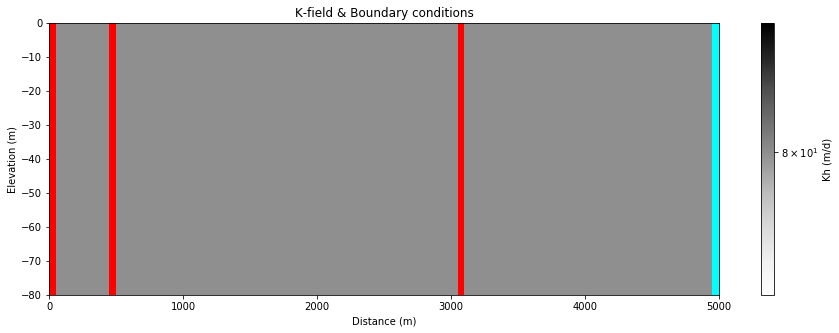

In [169]:
printyn = 0
gridon=0
m.plot_hk_ibound(rowslice=0,printyn=printyn,gridon=gridon);

In [170]:
#Write input
m.write_input()

# Try to delete the output files, to prevent accidental use of older files
try:
    os.remove(os.path.join(model_ws,'MT3D.CNF'))
    os.remove(os.path.join(model_ws,'MT3D001.MAS'))
    os.remove(os.path.join(model_ws, 'MT3D001.UCN'))
    os.remove(os.path.join(model_ws, modelname + '.hds'))
    os.remove(os.path.join(model_ws, modelname + '.cbc'))
except:
    pass


Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  GHB
   Package:  WEL
   Package:  LPF
   Package:  PCG
   Package:  OC
   Package:  BTN
   Package:  ADV
   Package:  DSP
   Package:  GCG
   Package:  SSM
   Package:  VDF
 


In [171]:
#Run model
import datetime
ts = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
v = m.run_model(silent=False, report=True)
for idx in range(-3, 0):
    print(v[1][idx])

FloPy is using the following  executable to run the model: /Users/ianpg/Documents/ProjectsLocal/SyntheticSWI/bin/modflow_macOS/swt_v4

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulting from their authorized or unauthorized
 use.


 Using NAME file: varheight.nam                                                                                                                                                                                           
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/12/03 18:13

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8044      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1003      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2767E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.5046E-02  [K,I,J]   25    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1635E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3638E-03  [K,I,J]   23    1   99
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.9639E-04  [K,I,J]   23    1   97
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2671E-04  [K,I,J]   22    1   97
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6245E-05  [K,I,J]   21    1   98
 Transport Step:    4   Step Size:   6.846     Total Elapsed Time:   80.376    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8036      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1005      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.7080E-05  [K,I,J]   21    1   98
 Transport Step:    7   Step Size:   5.116     Total Elapsed Time:   200.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5738      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5945E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1422E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2242E-02  [K,I,J]   25    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.5192E-03  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.1044E-03  [K,I,J]   23    1   99
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.2108E-04  [K,I,J]    4    1   98
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.5445E-05  [K,I,J]   22    1   98

 STRESS PERIOD NO.    3

  STRESS PERIOD    3 TIME STEP    1 FROM TIME =   200.00     TO    2435.2    

 Transport Step:    1   Step Size:   6.988     Total Elapsed Time:   206.99    
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7914      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1033      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2620E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.5231E-02  [K,I,J]   25    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1563E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3800E-03  [K,I,J]   23    1   99
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.9322E-04  [K,I,J]   23    1   97
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2828E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.7071E-05  [K,I,J]   21    1   98
 Transport Step:   22   Step Size:   7.031     Total Elapsed Time:   354.30    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7912      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1034      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6978      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9513E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2385E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4932E-02  [K,I,J]   25    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1437E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3596E-03  [K,I,J]   23    1   99
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.8793E-04  [K,I,J]   23    1   97
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2751E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6851E-05  [K,I,J]   21    1   98
 Transport Step:   44   Step Size:   7.209     Total Elapsed Time:   510.48    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6983      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9528E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7079      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9770E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2446E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.5136E-02  [K,I,J]   25    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1524E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3838E-03  [K,I,J]   23    1   99
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.9484E-04  [K,I,J]   23    1   97
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2996E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.7551E-05  [K,I,J]   21    1   98
 Transport Step:   70   Step Size:   7.339     Total Elapsed Time:   699.97    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7081      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9776E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7111      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9850E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2465E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.5201E-02  [K,I,J]   25    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1551E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3915E-03  [K,I,J]   23    1   99
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.9700E-04  [K,I,J]   23    1   97
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.3075E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.7774E-05  [K,I,J]   21    1   98
 Transport Step:   90   Step Size:   7.378     Total Elapsed Time:   847.21    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7112      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9853E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7069      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9193E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2494E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4729E-02  [K,I,J]   25    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1500E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.4082E-03  [K,I,J]   23    1   99
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.9308E-04  [K,I,J]   23    1   97
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.3122E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.8343E-05  [K,I,J]   21    1   98
 Transport Step:  113   Step Size:   7.399     Total Elapsed Time:   1017.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7056      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9048E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5097      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6124E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1910E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4123E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1046E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3163E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6891E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2218E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6451E-05  [K,I,J]   21    1   98
 Transport Step:  133   Step Size:   7.403     Total Elapsed Time:   1165.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5066      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6084E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5966E-01  [K,I,J]    1    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1869E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4119E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1023E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3119E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6764E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2150E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6306E-05  [K,I,J]   21    1   98
 Transport Step:  153   Step Size:   7.403     Total Elapsed Time:   1313.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5968E-01  [K,I,J]    1    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5972E-01  [K,I,J]    1    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1869E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4119E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1023E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3119E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6765E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2150E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6307E-05  [K,I,J]   21    1   98
 Transport Step:  165   Step Size:   7.403     Total Elapsed Time:   1402.1    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5973E-01  [K,I,J]    1    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5973E-01  [K,I,J]    1    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1870E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4117E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1023E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3118E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6766E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2150E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6308E-05  [K,I,J]   21    1   98
 Transport Step:  192   Step Size:   7.403     Total Elapsed Time:   1602.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5973E-01  [K,I,J]    1    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4117E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1023E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3117E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6768E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2150E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6310E-05  [K,I,J]   21    1   98
 Transport Step:  218   Step Size:   7.403     Total Elapsed Time:   1794.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5973E-01  [K,I,J]    1    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1870E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4117E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1023E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5973E-01  [K,I,J]    1    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1870E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4116E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1023E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3117E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6768E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2150E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6310E-05  [K,I,J]   21    1   98
 Transport Step:  237   Step Size:   7.403     Total Elapsed Time:   1935.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5973E-01  [K,I,J]    1    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5973E-01  [K,I,J]    1    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1871E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4115E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1023E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3117E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6769E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2150E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6311E-05  [K,I,J]   21    1   98
 Transport Step:  263   Step Size:   7.404     Total Elapsed Time:   2127.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5973E-01  [K,I,J]    1    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5973E-01  [K,I,J]    1    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1871E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4115E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3116E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6769E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2150E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6311E-05  [K,I,J]   21    1   98
 Transport Step:  286   Step Size:   7.404     Total Elapsed Time:   2298.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5973E-01  [K,I,J]    1    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5973E-01  [K,I,J]    1    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1871E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4115E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3116E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6770E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2150E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6312E-05  [K,I,J]   21    1   98
 Transport Step:    7   Step Size:   7.404     Total Elapsed Time:   2487.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5973E-01  [K,I,J]    1    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5980E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1871E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3116E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6770E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2150E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6312E-05  [K,I,J]   21    1   98
 Transport Step:   28   Step Size:   7.404     Total Elapsed Time:   2642.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5981E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5991E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1872E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3116E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6771E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2150E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6313E-05  [K,I,J]   21    1   98
 Transport Step:   56   Step Size:   7.404     Total Elapsed Time:   2842.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5991E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Transport Step:   81   Step Size:   7.404     Total Elapsed Time:   3028.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6000E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1872E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3116E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6771E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2150E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6313E-05  [K,I,J]   21    1   98
 Transport Step:   82   Step Size:   7.404     Total Elapsed Time:   3035.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6772E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2150E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6314E-05  [K,I,J]   21    1   98
 Transport Step:  100   Step Size:   7.404     Total Elapsed Time:   3168.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6007E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1872E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3116E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6772E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2150E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6013E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1872E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3116E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6772E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2150E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6314E-05  [K,I,J]   21    1   98
 Transport Step:  122   Step Size:   7.404     Total Elapsed Time:   3331.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6014E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6017E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1872E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6772E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6314E-05  [K,I,J]   21    1   98
 Transport Step:  136   Step Size:   7.404     Total Elapsed Time:   3435.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6018E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6023E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1872E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6772E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6314E-05  [K,I,J]   21    1   98
 Transport Step:  155   Step Size:   7.404     Total Elapsed Time:   3575.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6023E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6029E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1872E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6773E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6315E-05  [K,I,J]   21    1   98
 Transport Step:  179   Step Size:   7.404     Total Elapsed Time:   3753.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6030E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6033E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1873E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6773E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6315E-05  [K,I,J]   21    1   98
 Transport Step:  193   Step Size:   7.404     Total Elapsed Time:   3857.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6033E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6037E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1873E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6773E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6315E-05  [K,I,J]   21    1   98
 Transport Step:  212   Step Size:   7.404     Total Elapsed Time:   3997.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6038E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6773E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6315E-05  [K,I,J]   21    1   98
 Transport Step:  233   Step Size:   7.404     Total Elapsed Time:   4153.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6042E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1873E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. D

 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6773E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6315E-05  [K,I,J]   21    1   98
 Transport Step:  245   Step Size:   7.404     Total Elapsed Time:   4242.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6045E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1873E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6773E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6048E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1873E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6773E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6316E-05  [K,I,J]   21    1   98
 Transport Step:  260   Step Size:   7.404     Total Elapsed Time:   4353.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6048E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6054E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1873E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6774E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6316E-05  [K,I,J]   21    1   98
 Transport Step:  290   Step Size:   7.404     Total Elapsed Time:   4575.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6054E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1873E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6774E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6316E-05  [K,I,J]   21    1   98
 Transport Step:  323   Step Size:   7.404     Total Elapsed Time:   4819.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6060E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1873E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. D

 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6774E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6316E-05  [K,I,J]   21    1   98
 Transport Step:  354   Step Size:   7.404     Total Elapsed Time:   5049.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6065E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1873E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6774E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6069E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1873E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6774E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6317E-05  [K,I,J]   21    1   98
 Transport Step:  382   Step Size:   7.404     Total Elapsed Time:   5256.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6069E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6073E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1874E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6775E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6317E-05  [K,I,J]   21    1   98
 Transport Step:  410   Step Size:   7.404     Total Elapsed Time:   5462.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4961      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6074E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6076E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1874E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6775E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6317E-05  [K,I,J]   21    1   98
 Transport Step:  425   Step Size:   7.404     Total Elapsed Time:   5573.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6076E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Transport Step:  440   Step Size:   7.404     Total Elapsed Time:   5684.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6078E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1874E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6775E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6317E-05  [K,I,J]   21    1   98
 Transport Step:  441   Step Size:   7.404     Total Elapsed Time:   5692.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6081E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1874E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6775E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6317E-05  [K,I,J]   21    1   98
 Transport Step:  465   Step Size:   7.404     Total Elapsed Time:   5869.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6081E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6084E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1874E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6775E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6317E-05  [K,I,J]   21    1   98
 Transport Step:  492   Step Size:   7.404     Total Elapsed Time:   6069.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6084E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6087E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1874E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6776E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6318E-05  [K,I,J]   21    1   98
 Transport Step:  517   Step Size:   7.404     Total Elapsed Time:   6254.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6087E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6090E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1874E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6776E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6318E-05  [K,I,J]   21    1   98
 Transport Step:  545   Step Size:   3.641     Total Elapsed Time:   6458.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2984      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2089E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6776E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6318E-05  [K,I,J]   21    1   98
 Transport Step:   15   Step Size:   7.404     Total Elapsed Time:   6569.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6092E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1874E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. D

 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6776E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6318E-05  [K,I,J]   21    1   98
 Transport Step:   31   Step Size:   7.404     Total Elapsed Time:   6688.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6093E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1874E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6776E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. D

 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6318E-05  [K,I,J]   21    1   98
 Transport Step:   45   Step Size:   7.404     Total Elapsed Time:   6791.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6095E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1874E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6776E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6318E-05  [K,I,J]   21    1   98
 Transport Step:   46   Step Size:   7.404     Total Elapsed Time:   6799.1    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Transport Step:   65   Step Size:   7.404     Total Elapsed Time:   6939.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6097E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1874E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6776E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6318E-05  [K,I,J]   21    1   98
 Transport Step:   66   Step Size:   7.404     Total Elapsed Time:   6947.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6098E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1874E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6776E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6318E-05  [K,I,J]   21    1   98
 Transport Step:   83   Step Size:   7.404     Total Elapsed Time:   7073.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6098E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6099E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1874E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6776E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6318E-05  [K,I,J]   21    1   98
 Transport Step:   95   Step Size:   7.404     Total Elapsed Time:   7161.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6099E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6100E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1874E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6776E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6319E-05  [K,I,J]   21    1   98
 Transport Step:  112   Step Size:   7.404     Total Elapsed Time:   7287.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6100E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6777E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6319E-05  [K,I,J]   21    1   98
 Transport Step:  139   Step Size:   7.404     Total Elapsed Time:   7487.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6103E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1874E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. D

 Transport Step:  152   Step Size:   7.404     Total Elapsed Time:   7583.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6103E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1874E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6777E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6319E-05  [K,I,J]   21    1   98
 Transport Step:  153   Step Size:   7.404     Total Elapsed Time:   7591.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6104E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1874E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6777E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2151E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6319E-05  [K,I,J]   21    1   98
 Transport Step:  168   Step Size:   7.404     Total Elapsed Time:   7702.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6105E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6105E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6777E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6319E-05  [K,I,J]   21    1   98
 Transport Step:  181   Step Size:   7.404     Total Elapsed Time:   7798.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6105E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6319E-05  [K,I,J]   21    1   98
 Transport Step:  203   Step Size:   7.404     Total Elapsed Time:   7956.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6107E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6777E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6319E-05  [K,I,J]   21    1   98
 Transport Step:  204   Step Size:   7.404     Total Elapsed Time:   7964.0    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6108E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6777E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6319E-05  [K,I,J]   21    1   98
 Transport Step:  227   Step Size:   7.404     Total Elapsed Time:   8134.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6108E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6109E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6777E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6319E-05  [K,I,J]   21    1   98
 Transport Step:  246   Step Size:   7.404     Total Elapsed Time:   8275.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6109E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6777E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6319E-05  [K,I,J]   21    1   98
 Transport Step:  257   Step Size:   7.404     Total Elapsed Time:   8356.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6110E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. D

 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6777E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6319E-05  [K,I,J]   21    1   98
 Transport Step:  271   Step Size:   7.404     Total Elapsed Time:   8460.1    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6110E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. D

 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6319E-05  [K,I,J]   21    1   98
 Transport Step:  284   Step Size:   7.404     Total Elapsed Time:   8556.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6111E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6777E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6319E-05  [K,I,J]   21    1   98
 Transport Step:  285   Step Size:   7.4

 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6320E-05  [K,I,J]   21    1   98
 Transport Step:  304   Step Size:   7.404     Total Elapsed Time:   8704.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6112E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6777E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6320E-05  [K,I,J]   21    1   98
 Transport Step:  305   Step Size:   7.404     Total Elapsed Time:   8711.9    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6113E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6778E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6320E-05  [K,I,J]   21    1   98
 Transport Step:  324   Step Size:   7.404     Total Elapsed Time:   8852.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6113E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Transport Step:  341   Step Size:   7.405     Total Elapsed Time:   8978.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6114E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6778E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6320E-05  [K,I,J]   21    1   98
 Transport Step:  342   Step Size:   7.405     Total Elapsed Time:   8985.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6114E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6778E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6320E-05  [K,I,J]   21    1   98
 Transport Step:  361   Step Size:   7.405     Total Elapsed Time:   9126.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6114E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6115E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6778E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6320E-05  [K,I,J]   21    1   98
 Transport Step:  385   Step Size:   7.405     Total Elapsed Time:   9304.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6115E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6116E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6778E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6320E-05  [K,I,J]   21    1   98
 Transport Step:  401   Step Size:   7.405     Total Elapsed Time:   9422.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6116E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6320E-05  [K,I,J]   21    1   98
 Transport Step:  418   Step Size:   7.405     Total Elapsed Time:   9548.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6116E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6778E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6320E-05  [K,I,J]   21    1   98
 Transport Step:  419   Step Size:   7.4

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6117E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6778E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6320E-05  [K,I,J]   21    1   98
 Transport Step:  437   Step Size:   7.405     Total Elapsed Time:   9689.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6117E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6117E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6778E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6320E-05  [K,I,J]   21    1   98
 Transport Step:  450   Step Size:   7.405     Total Elapsed Time:   9785.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6118E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6118E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6778E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6320E-05  [K,I,J]   21    1   98
 Transport Step:  481   Step Size:   7.405     Total Elapsed Time:   10015.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6118E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6119E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4113E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6778E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6320E-05  [K,I,J]   21    1   98
 Transport Step:  508   Step Size:   7.405     Total Elapsed Time:   10215.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6119E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6778E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6320E-05  [K,I,J]   21    1   98
 Transport Step:  526   Step Size:   7.405     Total Elapsed Time:   10348.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6120E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6120E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6778E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6320E-05  [K,I,J]   21    1   98
 Transport Step:  549   Step Size:   7.405     Total Elapsed Time:   10519.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6120E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6121E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6778E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6320E-05  [K,I,J]   21    1   98
 Transport Step:  569   Step Size:   7.405     Total Elapsed Time:   10665.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6121E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6778E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6320E-05  [K,I,J]   21    1   98
 Transport Step:  589   Step Size:   7.405     Total Elapsed Time:   10813.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6121E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6778E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6121E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6778E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  608   Step Size:   7.405     Total Elapsed Time:   10954.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6121E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Transport Step:  627   Step Size:   7.405     Total Elapsed Time:   11095.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6122E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  628   Step Size:   7.405     Total Elapsed Time:   11102.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  652   Step Size:   7.405     Total Elapsed Time:   11280.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6122E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. D

 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  674   Step Size:   7.405     Total Elapsed Time:   11443.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6123E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  675   Step Size:   7.405     Total Elapsed Time:   11450.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  697   Step Size:   7.405     Total Elapsed Time:   11613.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6123E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6123E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  720   Step Size:   7.405     Total Elapsed Time:   11783.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6123E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6124E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  741   Step Size:   7.405     Total Elapsed Time:   11939.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6124E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6124E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  763   Step Size:   7.405     Total Elapsed Time:   12102.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6124E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6124E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  778   Step Size:   7.405     Total Elapsed Time:   12213.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6124E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6124E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  799   Step Size:   7.405     Total Elapsed Time:   12368.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6124E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  816   Step Size:   7.405     Total Elapsed Time:   12494.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6125E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6125E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  833   Step Size:   7.405     Total Elapsed Time:   12620.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6125E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6125E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  855   Step Size:   7.405     Total Elapsed Time:   12783.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6125E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. D

 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  886   Step Size:   7.405     Total Elapsed Time:   13013.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6125E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  887   Step Size:   7.405     Total Elapsed Time:   13020.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6126E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  913   Step Size:   5.934     Total Elapsed Time:   13211.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4291      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4508E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6126E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  944   Step Size:   7.405     Total Elapsed Time:   13441.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6126E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6126E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  974   Step Size:   7.405     Total Elapsed Time:   13663.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6126E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6126E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:   12   Step Size:   7.405     Total Elapsed Time:   13789.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6126E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:   35   Step Size:   7.405     Total Elapsed Time:   13960.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6127E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6127E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:   61   Step Size:   7.405     Total Elapsed Time:   14152.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6127E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6127E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:   84   Step Size:   7.405     Total Elapsed Time:   14322.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6127E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6127E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  115   Step Size:   7.405     Total Elapsed Time:   14552.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6127E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6127E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  141   Step Size:   7.405     Total Elapsed Time:   14745.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6127E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6127E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  165   Step Size:   7.405     Total Elapsed Time:   14922.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6127E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6128E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  187   Step Size:   7.405     Total Elapsed Time:   15085.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6128E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  221   Step Size:   7.405     Total Elapsed Time:   15337.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6128E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1875E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6128E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  252   Step Size:   7.405     Total Elapsed Time:   15566.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6128E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6128E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  275   Step Size:   7.405     Total Elapsed Time:   15737.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6128E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  309   Step Size:   7.405     Total Elapsed Time:   15986.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6128E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6128E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  337   Step Size:   7.405     Total Elapsed Time:   16194.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6128E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6128E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  359   Step Size:   7.405     Total Elapsed Time:   16357.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6128E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6128E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  376   Step Size:   7.405     Total Elapsed Time:   16482.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6128E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  392   Step Size:   7.405     Total Elapsed Time:   16601.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  412   Step Size:   7.405     Total Elapsed Time:   16749.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  437   Step Size:   7.405     Total Elapsed Time:   16934.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  460   Step Size:   7.405     Total Elapsed Time:   17104.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  485   Step Size:   7.405     Total Elapsed Time:   17290.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  518   Step Size:   7.405     Total Elapsed Time:   17534.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  544   Step Size:   7.405     Total Elapsed Time:   17726.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  562   Step Size:   7.405     Total Elapsed Time:   17860.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  587   Step Size:   7.405     Total Elapsed Time:   18045.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  614   Step Size:   7.405     Total Elapsed Time:   18245.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  640   Step Size:   7.405     Total Elapsed Time:   18437.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  670   Step Size:   7.405     Total Elapsed Time:   18658.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  693   Step Size:   7.405     Total Elapsed Time:   18828.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6129E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  727   Step Size:   7.405     Total Elapsed Time:   19080.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  752   Step Size:   7.405     Total Elapsed Time:   19265.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  772   Step Size:   7.405     Total Elapsed Time:   19413.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  799   Step Size:   7.405     Total Elapsed Time:   19613.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  824   Step Size:   7.405     Total Elapsed Time:   19798.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  848   Step Size:   7.405     Total Elapsed Time:   19976.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  872   Step Size:   7.405     Total Elapsed Time:   20154.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  898   Step Size:   7.405     Total Elapsed Time:   20346.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  925   Step Size:   7.405     Total Elapsed Time:   20546.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  954   Step Size:   7.405     Total Elapsed Time:   20761.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. D

 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step:  983   Step Size:   7.405     Total Elapsed Time:   20976.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1024E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step: 1009   Step Size:   7.405     Total Elapsed Time:   21167.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step: 1033   Step Size:   7.405     Total Elapsed Time:   21344.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step: 1060   Step Size:   7.405     Total Elapsed Time:   21544.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step: 1092   Step Size:   7.405     Total Elapsed Time:   21781.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6130E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step: 1093   Step Size:   7.4

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step: 1117   Step Size:   7.405     Total Elapsed Time:   21966.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step: 1136   Step Size:   7.405     Total Elapsed Time:   22107.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Transport Step: 1159   Step Size:   7.405     Total Elapsed Time:   22277.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step: 1160   Step Size:   7.405     Total Elapsed Time:   22285.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6779E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step: 1185   Step Size:   7.405     Total Elapsed Time:   22470.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Transport Step: 1207   Step Size:   7.405     Total Elapsed Time:   22633.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step: 1208   Step Size:   7.405     Total Elapsed Time:   22640.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step: 1231   Step Size:   7.405     Total Elapsed Time:   22810.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step: 1256   Step Size:   7.405     Total Elapsed Time:   22996.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step: 1279   Step Size:   7.405     Total Elapsed Time:   23166.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. D

 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step: 1301   Step Size:   7.405     Total Elapsed Time:   23329.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step: 1302   Step Size:   7.4

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step: 1327   Step Size:   7.405     Total Elapsed Time:   23521.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step: 1359   Step Size:   7.405     Total Elapsed Time:   23758.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. D

 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step: 1387   Step Size:   7.405     Total Elapsed Time:   23964.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step: 1408   Step Size:   7.405     Total Elapsed Time:   24120.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Transport Step: 1433   Step Size:   7.405     Total Elapsed Time:   24305.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step: 1434   Step Size:   7.405     Total Elapsed Time:   24312.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6321E-05  [K,I,J]   21    1   98
 Transport Step: 1468   Step Size:   7.405     Total Elapsed Time:   24564.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1491   Step Size:   7.405     Total Elapsed Time:   24734.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1520   Step Size:   7.405     Total Elapsed Time:   24949.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1542   Step Size:   7.405     Total Elapsed Time:   25112.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1572   Step Size:   7.405     Total Elapsed Time:   25334.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6131E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1596   Step Size:   7.405     Total Elapsed Time:   25512.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. D

 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1614   Step Size:   7.405     Total Elapsed Time:   25645.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. D

 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1638   Step Size:   7.405     Total Elapsed Time:   25823.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. D

 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1675   Step Size:   7.405     Total Elapsed Time:   26097.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1712   Step Size:   7.405     Total Elapsed Time:   26371.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1746   Step Size:   7.405     Total Elapsed Time:   26622.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:   16   Step Size:   7.405     Total Elapsed Time:   26854.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:   53   Step Size:   7.405     Total Elapsed Time:   27128.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:   91   Step Size:   7.405     Total Elapsed Time:   27410.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  128   Step Size:   7.405     Total Elapsed Time:   27684.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  163   Step Size:   7.405     Total Elapsed Time:   27943.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  199   Step Size:   7.405     Total Elapsed Time:   28210.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  234   Step Size:   7.405     Total Elapsed Time:   28469.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  268   Step Size:   7.405     Total Elapsed Time:   28720.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  302   Step Size:   7.405     Total Elapsed Time:   28972.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  340   Step Size:   7.405     Total Elapsed Time:   29249.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  379   Step Size:   7.405     Total Elapsed Time:   29538.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  415   Step Size:   7.405     Total Elapsed Time:   29804.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6132E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  443   Step Size:   7.405     Total Elapsed Time:   30012.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  476   Step Size:   7.405     Total Elapsed Time:   30256.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  509   Step Size:   7.405     Total Elapsed Time:   30501.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  542   Step Size:   7.405     Total Elapsed Time:   30745.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  579   Step Size:   7.405     Total Elapsed Time:   31019.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  617   Step Size:   7.405     Total Elapsed Time:   31300.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  653   Step Size:   7.405     Total Elapsed Time:   31567.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  685   Step Size:   7.405     Total Elapsed Time:   31802.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  717   Step Size:   7.405     Total Elapsed Time:   32039.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  753   Step Size:   7.405     Total Elapsed Time:   32306.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  790   Step Size:   7.405     Total Elapsed Time:   32580.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  827   Step Size:   7.405     Total Elapsed Time:   32854.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. D

 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  864   Step Size:   7.405     Total Elapsed Time:   33128.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. D

 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  900   Step Size:   7.405     Total Elapsed Time:   33394.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  936   Step Size:   7.405     Total Elapsed Time:   33661.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step:  971   Step Size:   7.405     Total Elapsed Time:   33920.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. D

 Transport Step: 1009   Step Size:   7.405     Total Elapsed Time:   34201.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1010   Step Size:   7.405     Total Elapsed Time:   34209.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1041   Step Size:   7.405     Total Elapsed Time:   34437.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1083   Step Size:   7.405     Total Elapsed Time:   34748.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1124   Step Size:   7.405     Total Elapsed Time:   35051.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1153   Step Size:   7.405     Total Elapsed Time:   35266.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1154   Step Size:   7.4

 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1192   Step Size:   7.405     Total Elapsed Time:   35555.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1193   Step Size:   7.4

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1230   Step Size:   7.405     Total Elapsed Time:   35836.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1271   Step Size:   7.405     Total Elapsed Time:   36140.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1311   Step Size:   7.405     Total Elapsed Time:   36436.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1350   Step Size:   7.405     Total Elapsed Time:   36725.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1388   Step Size:   7.405     Total Elapsed Time:   37005.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1428   Step Size:   7.405     Total Elapsed Time:   37301.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1466   Step Size:   7.405     Total Elapsed Time:   37582.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1506   Step Size:   7.405     Total Elapsed Time:   37879.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1547   Step Size:   7.405     Total Elapsed Time:   38182.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1589   Step Size:   7.405     Total Elapsed Time:   38493.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6133E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1633   Step Size:   7.405     Total Elapsed Time:   38819.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1676   Step Size:   7.405     Total Elapsed Time:   39137.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1710   Step Size:   7.405     Total Elapsed Time:   39389.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. D

 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1746   Step Size:   7.405     Total Elapsed Time:   39654.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1787   Step Size:   7.405     Total Elapsed Time:   39958.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1827   Step Size:   7.405     Total Elapsed Time:   40254.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1865   Step Size:   7.405     Total Elapsed Time:   40535.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1897   Step Size:   7.405     Total Elapsed Time:   40772.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1934   Step Size:   7.405     Total Elapsed Time:   41046.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 1974   Step Size:   7.405     Total Elapsed Time:   41343.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2017   Step Size:   7.405     Total Elapsed Time:   41661.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2060   Step Size:   7.405     Total Elapsed Time:   41979.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Transport Step: 2101   Step Size:   7.405     Total Elapsed Time:   42281.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2102   Step Size:   7.405     Total Elapsed Time:   42289.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2138   Step Size:   7.405     Total Elapsed Time:   42555.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2177   Step Size:   7.405     Total Elapsed Time:   42844.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2214   Step Size:   7.405     Total Elapsed Time:   43118.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2249   Step Size:   7.405     Total Elapsed Time:   43377.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2287   Step Size:   7.405     Total Elapsed Time:   43659.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2325   Step Size:   7.405     Total Elapsed Time:   43940.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2364   Step Size:   7.405     Total Elapsed Time:   44229.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2391   Step Size:   7.405     Total Elapsed Time:   44429.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2430   Step Size:   7.405     Total Elapsed Time:   44718.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2462   Step Size:   7.405     Total Elapsed Time:   44953.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. D

 Transport Step: 2498   Step Size:   7.405     Total Elapsed Time:   45220.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2499   Step Size:   7.405     Total Elapsed Time:   45227.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2533   Step Size:   7.405     Total Elapsed Time:   45479.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2534   Step Size:   7.4

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2569   Step Size:   7.405     Total Elapsed Time:   45745.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2594   Step Size:   7.405     Total Elapsed Time:   45930.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2595   Step Size:   7.405     Total Elapsed Time:   45938.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2629   Step Size:   7.405     Total Elapsed Time:   46190.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2677   Step Size:   7.405     Total Elapsed Time:   46545.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2725   Step Size:   7.405     Total Elapsed Time:   46900.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2769   Step Size:   7.405     Total Elapsed Time:   47226.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2810   Step Size:   7.405     Total Elapsed Time:   47530.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2853   Step Size:   7.405     Total Elapsed Time:   47847.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2899   Step Size:   7.405     Total Elapsed Time:   48187.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2941   Step Size:   7.405     Total Elapsed Time:   48498.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 2982   Step Size:   7.405     Total Elapsed Time:   48802.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 3020   Step Size:   7.405     Total Elapsed Time:   49083.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 3061   Step Size:   7.405     Total Elapsed Time:   49387.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 3062   Step Size:   7.405     Total Elapsed Time:   49394.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 3105   Step Size:   7.405     Total Elapsed Time:   49713.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1876E-01  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4114E-02  [K,I,J]   24    1   99
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1025E-02  [K,I,J]   24    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3115E-03  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6780E-04  [K,I,J]   22    1   99
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2152E-04  [K,I,J]   22    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6322E-05  [K,I,J]   21    1   98
 Transport Step: 3152   Step Size:   7.405     Total Elapsed Time:   50061.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4960      [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6134E-01  [K,I,J]   26    1   10
 Outer Iter.  1  Inner Iter.  3:  Max. D

## Post-processing results

In [177]:
#Post-processing functions
def plotdischarge(modelname,model_ws,color='w',per=-1,scale=50,rowslice=0):
    fname = os.path.join(model_ws, '' + modelname + '.cbc')
    budobj = flopy.utils.CellBudgetFile(fname)
    qx = budobj.get_data(text='FLOW RIGHT FACE')[per]
    qz = budobj.get_data(text='FLOW LOWER FACE')[per]
    
    # Average flows to cell centers
    qx_avg = np.empty(qx.shape, dtype=qx.dtype)
    qx_avg[:, :, 1:] = 0.5 * (qx[:, :, 0:ncol-1] + qx[:, :, 1:ncol])
    qx_avg[:, :, 0] = 0.5 * qx[:, :, 0]
    qz_avg = np.empty(qz.shape, dtype=qz.dtype)
    qz_avg[1:, :, :] = 0.5 * (qz[0:nlay-1, :, :] + qz[1:nlay, :, :])
    qz_avg[0, :, :] = 0.5 * qz[0, :, :]
    
    y, x, z = dis.get_node_coordinates()
    X, Z = np.meshgrid(x, z[:, 0, 0])
    iskip = 1 #how many cells to skip, 1 means plot every cell
    
    ax = plt.gca()
    cpatchcollection = ax.quiver(X[::iskip, ::iskip], Z[::iskip, ::iskip],
              qx_avg[::iskip, rowslice, ::iskip], -qz_avg[::iskip, rowslice, ::iskip],
              color=color, scale=scale, headwidth=4, headlength=2,
              headaxislength=1, width=0.0025)
    return cpatchcollection

def permute_kstpkper(ucnobj):
    kstpkper = ucnobj.get_kstpkper()
    kstpkper_unique = []
    index_unique = []
    niter = 0
    for entry in kstpkper:
        if not entry in kstpkper_unique:
            kstpkper_unique.append(entry)
            index_unique.append(niter)
        niter += 1
    return kstpkper_unique, index_unique

def kstpkper_from_time(ucnobj,tottim):
    kstpkpers = ucnobj.get_kstpkper()
    times = ucnobj.get_times()
    timeind = times.index(tottim)    
    kstpkper = kstpkpers[timeind]
    return kstpkper

def kstpkper_ind_from_kstpkper(ucnobj,kstpkper=(0,0)):
    kstpkpers = ucnobj.get_kstpkper()
    kstpkper_unique = permute_kstpkper(ucnobj)[0]
    kstpkper_ind = kstpkper_unique.index(kstpkper)
    return kstpkper_ind

def get_salt_outflow(m,kstpkper=None,totim=None):
    fname = os.path.join(m.model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.binaryfile.UcnFile(fname)
    totim = ucnobj.get_times()[-1]
    if kstpkper==None:
        kstpkper = ucnobj.get_kstpkper()[-1]
    ocean_conc = ucnobj.get_data(kstpkper=kstpkper)
    return ocean_conc
    
def plot_background(mm,array,label=None):
    if label==None:
        label = [k for k,v in globals().items() if v is array][-1]
    if label=='hk':
        norm=matplotlib.colors.LogNorm()
        vmin=hkClay
        vmax=hkSand
        cmap='jet'
    else:
        norm = None
        vmin=None
        vmax=None
        cmap='jet'
    cpatchcollection = mm.plot_array(array,cmap=cmap,norm=norm,vmin=vmin,vmax=vmax)
    cpatchcollection.set_label(label)
    return cpatchcollection,label

def plot_mas(m):
    # Load the mas file and make a plot of total mass in aquifer versus time
    fname = os.path.join(m.model_ws, 'MT3D001.MAS')
    mas = flopy.mt3d.Mt3dms.load_mas(fname)
    f = plt.figure()
    ax = f.add_subplot(1, 1, 1)
    plt.xlabel('Time (d)')
    plt.ylabel('Mass (kg)')
    plt.title('Mass of salt within model through time')
    lines = ax.plot(mas.time, mas.total_mass)
    plt.show()
    return mas

In [178]:
# Extract final timestep heads
fname = os.path.join(model_ws, '' + modelname + '.hds')
hdobj = flopy.utils.binaryfile.HeadFile(fname)
times = hdobj.get_times()
print('Head object kstpkper:',hdobj.get_kstpkper())
hds = hdobj.get_data(totim=times[-1])
hds[np.where(ibound != 1)] = np.nan

# Extract final timestep salinity
fname = os.path.join(model_ws, 'MT3D001.UCN')
ucnobj = flopy.utils.binaryfile.UcnFile(fname)
times = ucnobj.get_times()
conc = ucnobj.get_data(totim=times[-1])
conc[np.where(ibound != 1)] = np.nan

Head object kstpkper: [(0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (2, 2)]


In [179]:
#dense_overlying = np.zeros((nlay,nrow,ncol),dtype='float')
#hdmod = np.zeros((nlay,nrow,ncol),dtype='float')

#for lay in range(nlay):
#    dense_overlying[lay,:,:] = np.mean(conc[:lay,:,:],axis=0)*denseslp + densefresh
#hdmod = (dense_overlying-densefresh)/densefresh + hdmod
#hdmod[np.where(ibound != 1)] = np.nan
#plt.imshow(hdmod.squeeze())
#plt.colorbar()


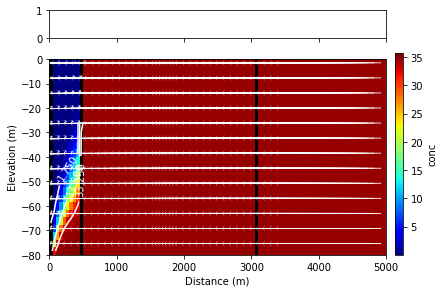

In [180]:
# Make head and quiver plot
import utils
printyn = 1
rowslice = 0
per=-1
f, axs = plt.subplots(2,1, sharex=True, figsize=(6, 4),
                     gridspec_kw = {'height_ratios':[1, 7]})
plt.tight_layout()

#Plot discharge and ibound
plt.sca(axs[1]) #set current axes
mm = flopy.plot.ModelCrossSection(ax=axs[1], model=m, line={'row':rowslice})

#Plot background
backgroundpatch,lbl = cpatchcollection,label = plot_background(mm,conc,'conc')
lvls = Cfresh + (Csalt-Cfresh)*np.array([.05,.5,.95])
CS = mm.contour_array(conc,head=hds,levels=lvls,colors='white')
plt.clabel(CS, CS.levels, inline=True, fontsize=10)

#mm.contour_array(hds,head=hds)
mm.plot_ibound()
mm.plot_bc(ftype='WEL',color='k')
#Plot discharge
utils.plotdischarge(m,color='white',per=-1,scale=10,rowslice=rowslice,iskip=2);
plt.xlabel('Distance (m)')
plt.ylabel('Elevation (m)')
plt.subplots_adjust(bottom=.1)

'''
#plot SGD
ocean_flow = 100 * np.asarray(utils.get_ocean_outflow_chd(m,ocean_bool=ocean_line_tuple))
plt.sca(axs[0]) #set current axes
#plt.bar(np.arange(ocean_col[0],ocean_col[1]+1)+delc/2,
#        ocean_flow[:,rowslice,:][ocean_bool[:,rowslice,:]])
rowslice_inds = np.where(ocean_line_tuple[1]==rowslice)[0]
plt.bar(np.arange(ocean_col[0],ocean_col[1]+1)+delc/2,
        ocean_flow[(ocean_line_tuple[0][rowslice_inds],
                    ocean_line_tuple[1][rowslice_inds],
                    ocean_line_tuple[2][rowslice_inds])])
axs[0].axhline()
axs[0].set_ylim(np.min(ocean_flow),np.max(ocean_flow))
plt.ylabel('SGD (cm/d)')
axs[0].annotate('total outflow = ' + str(np.sum(ocean_flow[np.where(ocean_flow>0)])) + 
                ' cm/d \n\ntotal inflow = ' + str(np.sum(ocean_flow[np.where(ocean_flow<0)])) +
                ' cm/d', xy=(.1,.5),
                xytext=(0.1, 0.3), xycoords='axes fraction', textcoords='axes fraction')

#Plot salt content of cells beneath outflow
#ocean_below_ind = [ocean_line_tuple[0]+1, #layer below ocean
#                   ocean_line_tuple[1],
#                   ocean_line_tuple[2]]   
#ind = np.where(ocean_below_ind[1] == rowslice)
#ocean_below_ind_slice = (ocean_below_ind[0][ind],
#                         ocean_below_ind[1][ind],
#                         ocean_below_ind[2][ind])
#ocean_salt_outflow = utils.get_salt_outflow(m,kstpkper = (nstp[-1]-1,nper-1))[ocean_below_ind_slice]
                   
                   
axs02 = axs[0].twinx()
#plt.plot(ocean_col_vec[2]+delc/2 , ocean_salt_outflow,'r.')
#plt.ylabel('conc \nunderlying (g/L)',rotation=90)
'''
#align plots and set colorbar
f.subplots_adjust(left=.1,right=0.88)
cbar_ax = f.add_axes([0.90, 0.1, 0.02, 0.7])
cb = f.colorbar(cpatchcollection,cax=cbar_ax)
cb.set_label(label)
if printyn == 1:
    plt.savefig(os.path.join(m.model_ws, m.name + '_' + ts + '_flowvec_row ' + str(rowslice) +
                             '_per' + str(per) + '_' + lbl + '.png'),dpi=150)
plt.show()

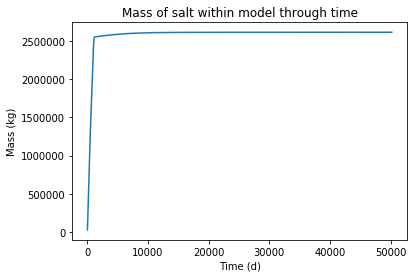

In [181]:
mas = plot_mas(m)

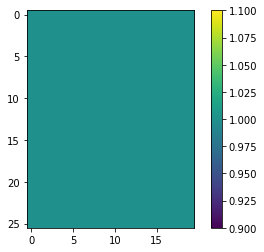

In [797]:
# Extract final timestep salinity
fname = os.path.join(model_ws, 'MT3D001.UCN')
ucnobj = flopy.utils.binaryfile.UcnFile(fname)
times = ucnobj.get_times()
conc = ucnobj.get_data(totim=times[-1])

plt.imshow(icbund[:,0,-20:]); plt.colorbar()

In [547]:
keep_running(m,[10,10,10000])

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfdis.ModflowDis'> <class 'flopy.modflow.mfdis.ModflowDis'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.mt3d.mtbtn.Mt3dBtn'> <class 'flopy.mt3d.mtbtn.Mt3dBtn'>
replacing existing Package...

Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  WEL
   Package:  LPF
   Package:  PCG
   Package:  OC
   Package:  BTN
   Package:  ADV
   Package:  DSP
   Package:  GCG
   Package:  SSM
   Package:  VDF
 
FloPy is using the following  executable to run the model: /Users/ianpg/Documents/ProjectsLocal/SyntheticSWI/bin/modflow_macOS/swt_v4

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006        

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2079E-01  [K,I,J]    8    2    2
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1109E-01  [K,I,J]    8    2    4
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3258E-02  [K,I,J]    8    1    2
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2159E-02  [K,I,J]    8    2    2
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.9743E-03  [K,I,J]    8    2    5
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.7138E-03  [K,I,J]    1    1    5
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.5163E-03  [K,I,J]    8    1    2
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.3170E-03  [K,I,J]    8    1    5
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.1511E-03  [K,I,J]    8    2    3
 Outer Iter.  1  Inner Iter. 10:  Max. DC =  0.1307E-03  [K,I,J]    8    1    1
 Outer Iter.  1  Inner Iter. 11:  Max. DC =  0.4515E-04  [K,I,J]    8    2    3
 Outer Iter.  1  Inner Iter. 12:  Max. DC =  0.4233E-04  [K,I,J]    8    1    3
 Outer Iter.  1  Inner Iter. 13:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8712E-02  [K,I,J]    8    2    4
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4863E-02  [K,I,J]    8    2    6
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2282E-02  [K,I,J]    8    2    6
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1431E-02  [K,I,J]    8    1    3
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.8643E-03  [K,I,J]    1    1   14
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.7431E-03  [K,I,J]    1    2   14
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.5990E-03  [K,I,J]    1    2   13
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.3347E-03  [K,I,J]    1    1   13
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.2096E-03  [K,I,J]    1    2   13
 Outer Iter.  1  Inner Iter. 10:  Max. DC =  0.1764E-03  [K,I,J]    1    1   13
 Outer Iter.  1  Inner Iter. 11:  Max. DC =  0.1086E-03  [K,I,J]    8    2    7
 Outer Iter.  1  Inner Iter. 12:  Max. DC =  0.4533E-04  [K,I,J]    1    1   13
 Outer Iter.  1  Inner Iter. 13:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6259E-02  [K,I,J]    8    2    5
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4665E-02  [K,I,J]    8    2    5
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2575E-02  [K,I,J]    8    1    6
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1531E-02  [K,I,J]    8    1    3
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.5269E-03  [K,I,J]    1    2   22
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.8493E-03  [K,I,J]    8    1    3
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.2928E-03  [K,I,J]    8    2    3
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.3137E-03  [K,I,J]    8    2    7
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.1118E-03  [K,I,J]    8    2    3
 Outer Iter.  1  Inner Iter. 10:  Max. DC =  0.1769E-03  [K,I,J]    8    1    3
 Outer Iter.  1  Inner Iter. 11:  Max. DC =  0.5025E-04  [K,I,J]    8    1    4
 Outer Iter.  1  Inner Iter. 12:  Max. DC =  0.4501E-04  [K,I,J]    8    2    4
 Outer Iter.  1  Inner Iter. 13:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4732E-02  [K,I,J]    8    1    6
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3178E-02  [K,I,J]    8    2    5
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2045E-02  [K,I,J]    8    2    5
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.9488E-03  [K,I,J]    1    2   27
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.7939E-03  [K,I,J]    1    1   27
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.7185E-03  [K,I,J]    1    2   27
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.3262E-03  [K,I,J]    8    1    3
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2945E-03  [K,I,J]    8    1    4
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.1309E-03  [K,I,J]    1    2   26
 Outer Iter.  1  Inner Iter. 10:  Max. DC =  0.1397E-03  [K,I,J]    8    1    4
 Outer Iter.  1  Inner Iter. 11:  Max. DC =  0.5477E-04  [K,I,J]    8    1   17
 Outer Iter.  1  Inner Iter. 12:  Max. DC =  0.4776E-04  [K,I,J]    8    1    7
 Outer Iter.  1  Inner Iter. 13:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6148E-02  [K,I,J]    8    2    4
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3243E-02  [K,I,J]    8    2    4
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1906E-02  [K,I,J]    7    2   15
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1266E-02  [K,I,J]    8    2    3
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.6161E-03  [K,I,J]    1    2   33
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.7532E-03  [K,I,J]    1    1   33
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.3285E-03  [K,I,J]    1    2   33
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2183E-03  [K,I,J]    1    1   33
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.1544E-03  [K,I,J]    7    1   14
 Outer Iter.  1  Inner Iter. 10:  Max. DC =  0.8978E-04  [K,I,J]    1    2   32
 Outer Iter.  1  Inner Iter. 11:  Max. DC =  0.7603E-04  [K,I,J]    7    1   14
 Outer Iter.  1  Inner Iter. 12:  Max. DC =  0.3142E-04  [K,I,J]    8    2    7
 Outer Iter.  1  Inner Iter. 13:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6144E-02  [K,I,J]    8    2    4
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3354E-02  [K,I,J]    8    2    4
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1806E-02  [K,I,J]    7    1   14
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1233E-02  [K,I,J]    7    1   14
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.6050E-03  [K,I,J]    1    2   41
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.6961E-03  [K,I,J]    1    1   41
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.3369E-03  [K,I,J]    1    2   41
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2066E-03  [K,I,J]    1    1   41
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.1433E-03  [K,I,J]    1    1   40
 Outer Iter.  1  Inner Iter. 10:  Max. DC =  0.8750E-04  [K,I,J]    1    2   40
 Outer Iter.  1  Inner Iter. 11:  Max. DC =  0.7140E-04  [K,I,J]    7    1   13
 Outer Iter.  1  Inner Iter. 12:  Max. DC =  0.3126E-04  [K,I,J]    6    1   20
 Outer Iter.  1  Inner Iter. 13:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5550E-02  [K,I,J]    8    1    4
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3324E-02  [K,I,J]    8    1    4
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1859E-02  [K,I,J]    8    1    3
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.9702E-03  [K,I,J]    7    1   14
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.5673E-03  [K,I,J]    1    2   43
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.6062E-03  [K,I,J]    1    1   43
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.2853E-03  [K,I,J]    1    2   43
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2015E-03  [K,I,J]    1    2   44
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.1543E-03  [K,I,J]    7    1   13
 Outer Iter.  1  Inner Iter. 10:  Max. DC =  0.7840E-04  [K,I,J]    1    2   44
 Outer Iter.  1  Inner Iter. 11:  Max. DC =  0.8066E-04  [K,I,J]    7    1   13
 Outer Iter.  1  Inner Iter. 12:  Max. DC =  0.3470E-04  [K,I,J]    6    1   21
 Outer Iter.  1  Inner Iter. 13:  Max. D

 Outer Iter.  1  Inner Iter. 14:  Max. DC =  0.1484E-04  [K,I,J]    6    2   20
 Outer Iter.  1  Inner Iter. 15:  Max. DC =  0.1582E-04  [K,I,J]    7    2   12
 Outer Iter.  1  Inner Iter. 16:  Max. DC =  0.5703E-05  [K,I,J]    1    2   46
 Transport Step:   17   Step Size:   66.02     Total Elapsed Time:   6443.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5194E-02  [K,I,J]    8    1    4
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3142E-02  [K,I,J]    8    1    4
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1754E-02  [K,I,J]    8    1    3
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8789E-03  [K,I,J]    7    1   14
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.6046E-03  [K,I,J]    1    2   48
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.6962E-03  [K,I,J]    7    1   14
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.2763E-03  [K,I,J]    1    1   53
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.1851E-03  [K,I,J]    1    2   53
 Outer Iter.  1  Inner Iter.  9:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4929E-02  [K,I,J]    8    1    4
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2863E-02  [K,I,J]    8    1    4
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1641E-02  [K,I,J]    7    1   14
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.9694E-03  [K,I,J]    7    1   14
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.5331E-03  [K,I,J]    1    2   56
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.6228E-03  [K,I,J]    7    2   14
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.2555E-03  [K,I,J]    1    2   56
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2023E-03  [K,I,J]    8    2    6
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.1473E-03  [K,I,J]    8    1    7
 Outer Iter.  1  Inner Iter. 10:  Max. DC =  0.8785E-04  [K,I,J]    8    1    8
 Outer Iter.  1  Inner Iter. 11:  Max. DC =  0.7148E-04  [K,I,J]    7    2   15
 Outer Iter.  1  Inner Iter. 12:  Max. DC =  0.3802E-04  [K,I,J]    8    2    7
 Outer Iter.  1  Inner Iter. 13:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4685E-02  [K,I,J]    8    2    4
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2528E-02  [K,I,J]    8    2    4
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1439E-02  [K,I,J]    7    1   14
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.6372E-03  [K,I,J]    8    1    4
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3844E-03  [K,I,J]    1    2   71
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.4944E-03  [K,I,J]    1    2   63
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.2682E-03  [K,I,J]    8    2    8
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.1905E-03  [K,I,J]    8    2    6
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.1019E-03  [K,I,J]    8    2    8
 Outer Iter.  1  Inner Iter. 10:  Max. DC =  0.1142E-03  [K,I,J]    8    1    8
 Outer Iter.  1  Inner Iter. 11:  Max. DC =  0.5981E-04  [K,I,J]    7    1   14
 Outer Iter.  1  Inner Iter. 12:  Max. DC =  0.2338E-04  [K,I,J]    8    2    7
 Outer Iter.  1  Inner Iter. 13:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4357E-02  [K,I,J]    8    2    4
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2552E-02  [K,I,J]    7    1   14
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1561E-02  [K,I,J]    7    1   15
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1049E-02  [K,I,J]    7    1   15
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.4597E-03  [K,I,J]    2    1   27
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.6311E-03  [K,I,J]    7    1   15
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.2772E-03  [K,I,J]    8    2    8
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.1638E-03  [K,I,J]    7    2   15
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.1579E-03  [K,I,J]    8    2    4
 Outer Iter.  1  Inner Iter. 10:  Max. DC =  0.9995E-04  [K,I,J]    8    1    8
 Outer Iter.  1  Inner Iter. 11:  Max. DC =  0.7929E-04  [K,I,J]    8    2    4
 Outer Iter.  1  Inner Iter. 12:  Max. DC =  0.2809E-04  [K,I,J]    7    2   18
 Outer Iter.  1  Inner Iter. 13:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4219E-02  [K,I,J]    8    2    4
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2278E-02  [K,I,J]    7    2   14
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1846E-02  [K,I,J]    7    1   15
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1073E-02  [K,I,J]    7    1   15
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3531E-03  [K,I,J]    1    2   73
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.5350E-03  [K,I,J]    7    1   15
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.3304E-03  [K,I,J]    8    2    8
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2193E-03  [K,I,J]    8    1    8
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.1260E-03  [K,I,J]    6    1   23
 Outer Iter.  1  Inner Iter. 10:  Max. DC =  0.7680E-04  [K,I,J]    1    2   72
 Outer Iter.  1  Inner Iter. 11:  Max. DC =  0.7052E-04  [K,I,J]    7    1   16
 Outer Iter.  1  Inner Iter. 12:  Max. DC =  0.5026E-04  [K,I,J]    6    2   23
 Outer Iter.  1  Inner Iter. 13:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4226E-02  [K,I,J]    8    1    4
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2403E-02  [K,I,J]    7    1   15
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1893E-02  [K,I,J]    7    1   16
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7444E-03  [K,I,J]    7    2   16
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.5211E-03  [K,I,J]    7    1   16
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.6091E-03  [K,I,J]    7    2   16
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.2704E-03  [K,I,J]    7    2   15
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.1364E-03  [K,I,J]    7    1   16
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.1604E-03  [K,I,J]    6    2   24
 Outer Iter.  1  Inner Iter. 10:  Max. DC =  0.9055E-04  [K,I,J]    6    1   24
 Outer Iter.  1  Inner Iter. 11:  Max. DC =  0.7536E-04  [K,I,J]    7    1   13
 Outer Iter.  1  Inner Iter. 12:  Max. DC =  0.4360E-04  [K,I,J]    6    1   24
 Outer Iter.  1  Inner Iter. 13:  Max. D

# Reading in real data

In [452]:
import pandas
from pathlib import Path
ws = Path(m.model_ws)
basedir = ws.joinpath('..','..')
datadir = basedir.joinpath('data')
fname = datadir.joinpath('seepage_flow_2015.xlsx')
flowsheet = pandas.read_excel(fname,skiprows=1)
print('Columns: ',flowsheet.columns)


Columns:  Index(['Row', 'Column', 'X', 'Y', 'Z', 'MeterNo', 'Flow', 'EC_IN', 'pctFW',
       'FlowFW', 'FlowSW'],
      dtype='object')


cmap='jet'

plt.scatter(flowsheet.X,flowsheet.Y,s=flowsheet.Flow,c=100-flowsheet.pctFW,cmap=cmap,vmin=0,vmax=100)


printyn = 0
layer= 1
cmap='jet'
f = plt.figure(figsize=(4, 10))
ax = plt.subplot()
ax.set_xlabel('X UTM (m)')
ax.set_ylabel('Y UTM (m)')
modmap = flopy.plot.ModelMap(model=m,ax=ax,rotation=rotation,xul=xul,yul=yul,layer=layer)

modmap.plot_ibound()
ax.set_aspect('equal')
scat = plt.scatter(flowsheet.X,flowsheet.Y,c=100-flowsheet.pctFW,cmap=cmap,vmin=0,vmax=100)
#cpatchcollection = modmap.plot_array(conc,cmap=cmap)
cb= f.colorbar(scat)
#cb.set_label('Concentration (g/L)')
cb.set_label('Pct Saltwater')

if printyn == 1:
    plt.savefig(os.path.join(m.model_ws, m.name + '_topview_lay ' + str(layer) +
                             '_per' + str(per) + '.png'),dpi=300)
plt.show()

#Issue: which "flow" is the correct flow?
    #Can get flow from the cell-by-cell file in either FLOW RIGHT FACE and FLOW LOWER FACE
    # Or from the constant head flow

ocean_flow = get_ocean_outflow(m,ocean_col);
print('total flow into ocean cells from const. head flow:',-np.sum(ocean_flow),'m^3/d')

fname = os.path.join(model_ws, '' + modelname + '.cbc')
budobj = flopy.utils.CellBudgetFile(fname)
qx = budobj.get_data(text='FLOW RIGHT FACE')[-1]
qz = budobj.get_data(text='FLOW LOWER FACE')[-1]
tot_flow = np.sum( np.sqrt(np.square(-qz[ocean_coords]) + np.square(qx[ocean_coords])))
print('Total flow from lower-right face in cbc file', tot_flow ,'m^3/d' )

In [453]:
lvls = (Csalt-Cfresh)*np.array([.05,.5,.95]) + Cfresh

indtop = np.where(verts[:,0] > botm_vector[0])[0]
indbot = np.where(verts[:,0] < botm_vector[-2])[0]
inds = np.hstack((indtop,indbot))


p = CS.collections[2].get_paths()[0]
v = p.vertices
x = v[:,0]
y = v[:,1]
plt.scatter(x,y)
plt.scatter(verts[inds][:,2],verts[inds][:,0])
plt.axis('equal')

def extract_contourpoints_2d(np_array,levels):
    if len(np_array.shape) == 2:
        CS = plt.contour(array,levels=lvls);
    elif len(np_array.shape) > 2:
        pass
        #do something
    return
print(x[0],x[-1])
print(y[0],y[-1])

print(verts[indtop])
print(verts[indbot])



NameError: name 'verts' is not defined

In [ ]:
def keep_running(m,new_perlen):
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.binaryfile.UcnFile(fname)
    conc = ucnobj.get_data(totim=ucnobj.get_times()[-1])
    new_sconc = np.abs(np.round(conc,decimals=1))
    new_sconc[ocean_line_tuple] = Csalt
    new_sconc[right_edge] = Csalt
    new_sconc[:,:,0] = Cfresh
    new_sconc[np.isnan(new_sconc)] = 0.
    # Add DIS package to the MODFLOW model
    dis = flopy.modflow.ModflowDis(m, nlay, nrow, ncol, nper=nper, delr=delr,
                                   delc=delc, xul=xul, yul=yul, rotation=rotation,
                                   laycbd=0, top=henry_top,
                                   botm=henry_botm, perlen=new_perlen, nstp=nstp,
                                   steady=steady,itmuni=itmuni,lenuni=lenuni,
                                   tsmult=tsmult)

    #Create the basic MT3DMS model structure
    btn = flopy.mt3d.Mt3dBtn(m, 
                             laycon=lpf.laytyp, htop=henry_top, 
                             dz=dis.thickness.get_value(), prsity=0.2, icbund=icbund,
                             sconc=new_sconc)
    #Write input
    m.write_input()
    # Try to delete the output files, to prevent accidental use of older files
    try:
        os.remove(os.path.join(model_ws,'MT3D.CNF'))
        os.remove(os.path.join(model_ws,'MT3D001.MAS'))
        os.remove(os.path.join(model_ws, 'MT3D001.UCN'))
        os.remove(os.path.join(model_ws, modelname + '.hds'))
        os.remove(os.path.join(model_ws, modelname + '.cbc'))
    except:
        pass
    m.run_model()
    return

In [ ]:
keep_running(m,[1000,1000,1000])

In [ ]:
import numpy as np
from numpy import sin, cos, pi
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

verts, faces, norms, vals = measure.marching_cubes(conc, level=lvls[1], spacing=(-delv, delc, delr))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(verts[:, 2], verts[:,1], faces, verts[:, 0],
                cmap='Spectral', lw=1)
plt.xlabel('Distance (m) columns')
plt.ylabel('Distance (m) rows')
plt.show()

In [473]:
get_angles(verts,norms,botm_vector)

NameError: name 'verts' is not defined

In [472]:
#Functions for extracting 'return variables' from data
def get_inds(verts,botm_vector):
    indtop = np.where(verts[:,0] > botm_vector[0])[0]
    indbot = np.where(verts[:,0] < botm_vector[-2])[0]
    return indtop,indbot

def get_angles(verts,norms,botm_vector):
    #takes the verts and norms arrays that are outputs of 
    #skimage.measure.marching_cubes()
    #Returns:
    #   theta_top:  avg angle between horizontal and topmost (tip) values
    #   theta_botm: avg angle between horizontal and bottommost (toe) values
    #   theta_avg:  avg angle between toe and tip. Defined as theta in Badaruddin et al., 2017
    indtop,indbot = get_inds(verts,botm_vector)
    horznorm = [1,0,0] #in lay,row,col format i.e. z,y,x
    theta_top = np.mean(np.arccos(np.dot(norms[indtop],horznorm)))
    theta_botm = np.mean(np.arccos(np.dot(norms[indbot],horznorm)))
    theta_avg = np.arctan(
        (np.mean(verts[indtop][:,0]) - np.mean(verts[indbot][:,0]))
        /(np.mean(verts[indtop][:,2]) - np.mean(verts[indbot][:,2])))
    return [theta_top,theta_botm,theta_avg]

def get_avg_width_dist(array, lvls, spacing=None):
    #calls the function skimage.measure.marching_cubes()
    #to retrieve estimates on transition zone parameters
    #returns np.nan if the value cannot be calculated because the contour hits the edge of model
    #Input arguments:
    #   array: 3-d array to be contoured
    #   lvls: list of length 2, used for contouring. Should be in ascending order!
    #   spacing: tuple of the spacing of input array, i.e. (delv,delc,delr) for MODFLOW arrays
    #Returns:
    #   width_tip_avg: avg topmost width between the two values in lvls
    #   width_toe_avg: avg bottommost width between the two values in lvls
    #   xtip_avg:      avg topmost x-position of the first input of lvls in dimensions of the array  
    #   xtoe_avg:      avg bottommost x-position of the first input of lvls in dimensions of the array  
    if spacing is None:
        spacing = (-delv, delc, delr)
    indtop_all,indbot_all = [],[]
    verts,faces,norms,vals = {},{},{},{}
    for i,lvl in enumerate(lvls):
        verts[i], faces[i], norms[i], vals[i] = measure.marching_cubes(conc, level=lvl, spacing=spacing)
        indtop,indbot = get_inds(verts[i],botm_vector)
        indtop_all.append(indtop)
        indbot_all.append(indbot)
    test_bot = [indarray.size for indarray in indbot_all]
    test_top = [indarray.size for indarray in indtop_all]
    if 0 in test_top:
        warnings.warn('\n -->Full tip not within model. Placing nan as stand-in<---')
        width_tip_avg = np.nan
    else:
        width_tip_avg = np.mean(verts[1][indtop_all[1]] - verts[0][indtop_all[0]],axis=0)[2]
    
    if 0 in test_bot:
        warnings.warn('\n -->Full toe not within model. Placing nan as stand-in<---')
        width_toe_avg = np.nan
    else:
        width_toe_avg = np.mean(verts[1][indbot_all[1]] - verts[0][indbot_all[0]],axis=0)[2]

    if test_bot[0]==0:
        warnings.warn('\n -->Toe x-pos not within model. Placing nan as stand-in<---')
        xtoe_avg = np.nan
    else:
        xtoe_avg = np.mean(verts[0][indbot_all[0]],axis=0)[2]
        
    if test_top[0]==0:
        warnings.warn('\n -->Tip x-pos not within model. Placing nan as stand-in<---')
        xtip_avg = np.nan
    else:
        xtip_avg = np.mean(verts[0][indtop_all[0]],axis=0)[2]
        
    return width_tip_avg,width_toe_avg,xtip_avg,xtoe_avg

In [ ]:
theta

In [ ]:
np.dot(norms[ind[0]],horznorm)

In [ ]:
ind